# Install

In [ ]:
!pip install unidecode
!pip install langdetect
!pip install langid
!pip install pyldavis

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Imports

In [ ]:
import csv
import numpy as np
import pandas as pd
import seaborn as sb
import re
import os
import joblib

from scipy import stats
from scipy import sparse
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as scdist

from IPython.display import display, HTML
import statsmodels.sandbox.stats.multicomp as mc

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob
import collections
import unidecode
import langid
import seaborn as sns

from bs4 import BeautifulSoup
from langdetect import detect, detect_langs

from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Import the wordcloud library
from wordcloud import WordCloud

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# from pyLDAvis import sklearn as sklearn_lda
import pickle 

import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

sns.set_style('whitegrid')
sb.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

lemmatizer = WordNetLemmatizer()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Functions

**Stopwords**

In [ ]:
file_stops = open('/content/drive/My Drive/covid-es-shared/notebooks/files/stop_words.txt')
file_stops = file_stops.read()
stops = file_stops.split()

# Stopwords personlized
stops_corpus = ['covid', 'covid19', 'covid-19', 'corona', 'coronavirus', 'coronovírus', 'nconv', 'virus', 'pandemic', 'https', 'print', 'array', 'input']

stops = set(stops + stops_corpus)

print("Stopwords:", len(stops))

Stopwords: 832


**Constants**

In [ ]:
min_length = 3

In [ ]:
# Detect English text

def is_en(text):
  #lang = TextBlob(para)  
  #i1   = lang.detect_language()
  i2   = detect(text)
  i3   = langid.classify(text)[0]

  return i2 == "en" or i3 == "en" # i1 == "en" or

In [ ]:
def remove_tag_code(html_text):
  soup = BeautifulSoup(html_text, "lxml")
  codes = soup("code")
  for code in codes:
    code.decompose()
  return soup.text
  
def textblob_tokenizer_text(str_input):
    letters_only = re.sub(u'[^a-záéíóúâêîôãõç ]', ' ', str_input)
    tokens = nltk.word_tokenize(letters_only)
    tokens = [unidecode.unidecode(token) for token in tokens if not token in stops and len(token) >= min_length]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]   
    text = ' '.join(tokens)

    if len(text) > min_length:
      return text

    return ""

def textblob_tokenizer_html(str_input):
    return textblob_tokenizer_text(remove_tag_code(str_input))

In [ ]:
def generate_cloud(df, column_text_processed, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue'):
  # Join the different processed titles together.
  long_string = ','.join(list(df[column_text_processed].values))
  # Create a WordCloud object
  wordcloud = WordCloud(background_color=background_color, max_words=max_words, contour_width=contour_width, contour_color=contour_color)
  # Generate a word cloud
  wordcloud.generate(long_string)
  # Visualize the word cloud
  # wordcloud.to_image()

  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

In [ ]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [ ]:
def preprocessing(df, column_text, column_text_processed="processed", is_html=False, check_language=False, min_df=5, max_df=0.8, ngram_range=(1, 1)):
  
  print("Load dataframe shape: ", df.shape)

  df = df.dropna(subset=[column_text])
  df = df[ (df[column_text].notnull()) & (df[column_text]!=u'') ]

  print("After removing invalid values:", df.shape)
  
  texts = df[column_text].str.lower()

  if is_html:
    df[column_text_processed] = [textblob_tokenizer_html(text) for text in texts]
  else:
    df[column_text_processed] = [textblob_tokenizer_text(text) for text in texts]

  df = df.dropna(subset=[column_text_processed])
  df = df[ (df[column_text_processed].notnull()) & (df[column_text_processed]!=u'') ]

  print("After removing blank values in text processing: ", df.shape)

  df['ID'] = range(df.shape[0])
  df.reset_index(drop=True, inplace=True)

  if check_language:
    drop_list = []

    # Remove unwritten text in English
    for index in df.index:
      text = (df[column_text_processed])[index]
      if not is_en(text):
        # print(index, " >>> ", text)
        drop_list.append(index)
    
    df.drop(df.index[drop_list], inplace=True)

    print("After removing unwritten text in English:", df.shape)

  # Initialise the count vectorizer with the English stop words
  count_vectorizer = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df, ngram_range=ngram_range)

  # Fit and transform the processed titles
  count_data = count_vectorizer.fit_transform(df[column_text_processed])

  tfidf_vectorizer = TfidfVectorizer(**count_vectorizer.get_params())
  dtm_tfidf = tfidf_vectorizer.fit_transform(df[column_text_processed])

  return count_vectorizer, count_data, tfidf_vectorizer, dtm_tfidf, df, column_text_processed

In [ ]:
def generate_lda(data, number_topics):
  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(data)

  return lda

In [ ]:
def add_topics(df, lda, data):
  results = lda.transform(data)
  num_topics = len(results[0])

  topics_names = ["topic_" + str(topic) for topic in range(1, num_topics + 1)]
  topic_encoded_df = pd.DataFrame(results, columns=topics_names)
  df[topics_names] = pd.DataFrame(results, index=df.index)

  topics = []

  for topic in results:
    max_value = max(topic)
    i, = np.where(np.isclose(topic, max_value))
    topics.append(i[0] + 1)

  df['topic'] = topics

  return df

In [ ]:
def generate_topics(df, column_text, column_text_processed, is_html, number_topics, with_tfidf=True, check_language=False):

  count_vectorizer, count_data, tfidf_vectorizer, dtm_tfidf, df, _ = preprocessing(df, column_text, column_text_processed=column_text_processed, is_html=is_html, check_language=check_language)

  #Save vectorizer.vocabulary_
  pickle.dump(count_vectorizer.vocabulary_,open("count_vectorizer.pkl","wb"))
  pickle.dump(tfidf_vectorizer.vocabulary_,open("tfidf_vectorizer.pkl","wb"))

  generate_cloud(df, column_text_processed)
  plot_10_most_common_words(count_data, count_vectorizer)

  if with_tfidf:
    lda = generate_lda(dtm_tfidf, number_topics)
    joblib.dump(lda, "lda_tfidf_{}_model.jl".format(number_topics))
    preparedData = pyLDAvis.sklearn.prepare(lda, dtm_tfidf, tfidf_vectorizer)
    pyLDAvis.save_html(preparedData, "topics_{}_tfidf.html".format(number_topics))
    df = add_topics(df, lda, dtm_tfidf)
  else:
    lda = generate_lda(count_data, number_topics)
    joblib.dump(lda, "lda_count_{}_model.jl".format(number_topics))
    preparedData = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)
    pyLDAvis.save_html(preparedData, "topics_{}_count.html".format(number_topics))
    df = add_topics(df, lda, count_data)

  return preparedData, df

In [ ]:
def load_count_vectorizer(file_name):
  return CountVectorizer(vocabulary=pickle.load(open(file_name, "rb")))

def load_tfidf_vectorizer(file_name):
  return TfidfVectorizer(vocabulary=pickle.load(open(file_name, "rb")))

def load_lda(file_name):
  return joblib.load(file_name)

# Stack Overflow

Load dataframe shape:  (1190, 2)
After removing invalid values: (1190, 2)
After removing blank values in text processing:  (1189, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


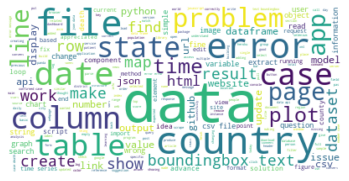

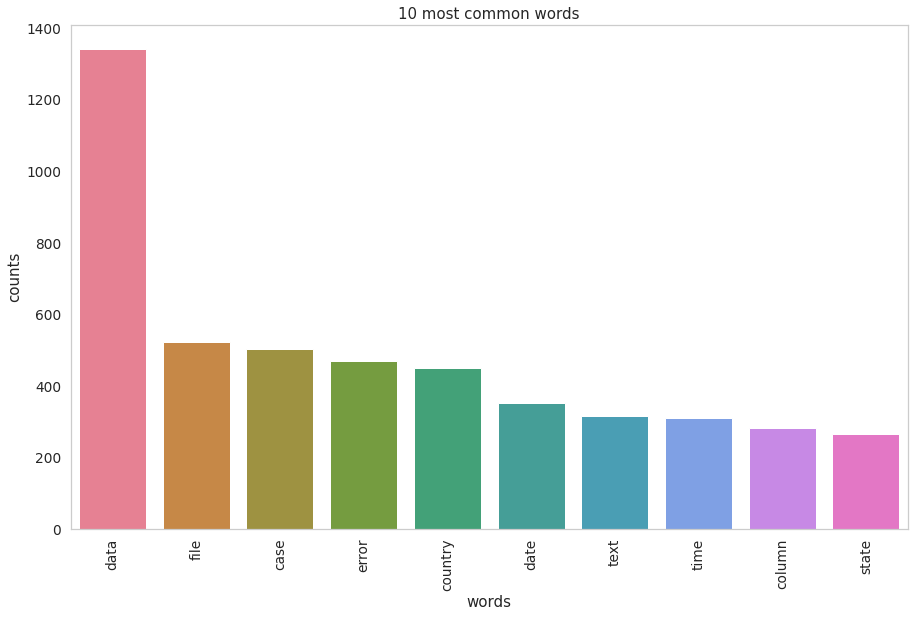

In [ ]:
number_topics = 7
column_text = 'Body'
column_text_processed = 'body_processed'
is_html = True
with_tfidf = True
check_language = False # Check manual

# Load dataframe
df = pd.read_csv('/content/drive/My Drive/covid-es-shared/database/raw_text_selected.csv', sep=',', quoting=csv.QUOTE_ALL)

preparedData, df = generate_topics(df, column_text, column_text_processed, is_html, number_topics, with_tfidf, check_language)

In [ ]:
preparedData

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.081513 -0.101152       1        1  31.104831
0     -0.054606  0.005880       2        1  22.815759
3      0.078639  0.064572       3        1  12.153783
6     -0.051367  0.002460       4        1  11.527926
2      0.029237  0.067921       5        1   8.532325
4     -0.034024 -0.021525       6        1   7.010843
5     -0.049391 -0.018156       7        1   6.854533, topic_info=         Term       Freq      Total Category  logprob  loglift
333     error  39.000000  39.000000  Default  30.0000  30.0000
1046    tweet   8.000000   8.000000  Default  29.0000  29.0000
35        api  24.000000  24.000000  Default  28.0000  28.0000
549      json  22.000000  22.000000  Default  27.0000  27.0000
690    output  17.000000  17.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
126      case   1.451919  32.340476   Topic7  -5.3371  -0.4232
116    button   1.278348  11.393630   Topic7  -5.4644   0.4928
761   problem   1.329172  19.347723   Topic7  -5.4254   0.0022
35        api   1.339370  24.759504   Topic7  -5.4178  -0.2368
788    python   1.255489  16.372234   Topic7  -5.4825   0.1122

[419 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6         1  0.254707      achieve
6         7  0.254707      achieve
19        5  0.598875       affect
19        6  0.598875       affect
20        3  0.501265  afghanistan
...     ...       ...          ...
1109      3  0.285657        world
1109      5  0.285657        world
1111      3  0.626184    worldwide
1126      4  0.459323         zoom
1126      7  0.459323         zoom

[766 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 7, 3, 5, 6])

In [ ]:
df

,Id,Body,body_processed,ID,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic
0,60548604,<p>Through other SO questions I've found how t...,question headline google store link wanting co...,0,0.039209,0.764736,0.039176,0.039205,0.039198,0.039223,0.039253,2
1,60635909,<p>I am using a dataset showing Corona Virus d...,dataset showing data loaded panda dataframe gi...,1,0.026475,0.841176,0.026466,0.026492,0.026460,0.026458,0.026473,2
2,72695,<p>I am searching for trends and dataset in bo...,searching trend dataset csv api format predict...,2,0.033920,0.796676,0.033870,0.033890,0.033905,0.033848,0.033891,2
3,61462376,<p>The for loop does not work if I use the $DA...,loop work daysdiff variable work number day da...,3,0.038517,0.038528,0.150813,0.475411,0.219770,0.038496,0.038466,4
4,61639535,<p>I'm trying to make a bubble plot of deaths ...,make bubble plot death shiny forgive obvious c...,4,0.796673,0.033971,0.033856,0.033980,0.033866,0.033833,0.033821,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1184,61710311,<p>This is my very first post on stackoverflow...,post stackoverflow explain struggle choropleth...,1184,0.766662,0.086674,0.029264,0.029332,0.029318,0.029512,0.029238,1
1185,61710868,<p>I am trying to write a script which will cy...,write script cycle worksheet workbook delete w...,1185,0.806857,0.032415,0.031947,0.032124,0.032011,0.031973,0.032672,1
1186,61711506,<p>I tried to create an interactive choropleth...,create interactive choropleth plot confirmed c...,1186,0.814190,0.031096,0.030955,0.030988,0.030934,0.030905,0.030933,1
1187,61711600,<p>I am learning flutter and trying to parse a...,learning flutter parse json article error lib ...,1187,0.412457,0.034212,0.034388,0.034142,0.034235,0.416096,0.034470,6


# GitHub

Load dataframe shape:  (61611, 18)
After removing invalid values: (38267, 18)
After removing blank values in text processing:  (36889, 19)
After removing unwritten text in English: (27284, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


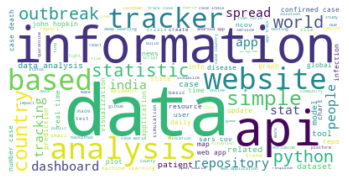

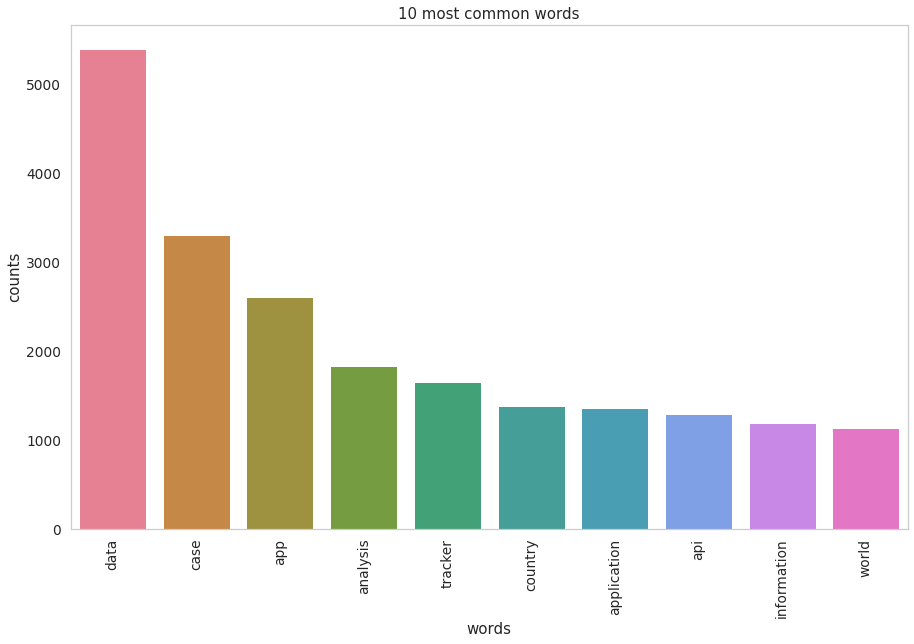

In [ ]:
number_topics = 11
column_text = 'description'
column_text_processed = 'description_processed'
is_html = False
with_tfidf = True
check_language = True

# Load dataframe
df2 = pd.read_csv('/content/drive/My Drive/covid-es-shared/report/20200604_COVID19_Github_Data.csv', sep=';', quoting=csv.QUOTE_ALL)
# df2 = df2.drop(columns=['Unnamed: 0'], axis=1)

preparedData, df2 = generate_topics(df2, column_text, column_text_processed, is_html, number_topics, with_tfidf, check_language=True)

In [ ]:
preparedData

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.229175  0.001663       1        1  14.672073
10    -0.108545  0.111108       2        1  10.651677
9      0.067138  0.248886       3        1  10.239349
2      0.032746  0.043273       4        1   9.011102
6      0.148158 -0.069712       5        1   8.743396
1      0.213519  0.003143       6        1   8.044496
5     -0.073392  0.079758       7        1   7.922919
3      0.138573 -0.056681       8        1   7.866645
8      0.015353 -0.191005       9        1   7.754788
7     -0.060888 -0.046516      10        1   7.620944
4     -0.143487 -0.123917      11        1   7.472611, topic_info=          Term        Freq        Total Category  logprob  loglift
2843   tracker  774.000000   774.000000  Default  30.0000  30.0000
103   analysis  643.000000   643.000000  Default  29.0000  29.0000
2258     react  379.000000   379.000000  Default  28.0000  28.0000
298        bot  201.000000   201.000000  Default  27.0000  27.0000
2664     stats  288.000000   288.000000  Default  26.0000  26.0000
...        ...         ...          ...      ...      ...      ...
3032   website   32.016200   370.295141  Topic11  -4.8770   0.1459
2928      user   23.786895    98.053718  Topic11  -5.1742   1.1775
688       data   28.154434  1129.091943  Topic11  -5.0056  -1.0975
2608    source   23.315640   176.880849  Topic11  -5.1942   0.5676
1589      live   23.037563   237.017449  Topic11  -5.2062   0.2629

[687 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
22        2  0.964241    active
32       11  0.816683  addition
44        9  0.942171  advanced
51        1  0.226548  affected
51        2  0.693804  affected
...     ...       ...       ...
3082      3  0.884781     wuhan
3082      6  0.073732     wuhan
3082      7  0.024577     wuhan
3083      2  0.944359   xamarin
3086      5  0.941746      xray

[1673 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 10, 3, 7, 2, 6, 4, 9, 8, 5])

In [ ]:
df = pd.read_csv('/content/drive/My Drive/covid-es-shared/report/20200604_COVID19_Github_Data.csv', sep=';', quoting=csv.QUOTE_ALL)
df = df.drop(columns=['Unnamed: 0'], axis=1)
df['ID'] = range(df.shape[0])

df2 = df2.drop(columns=['name', 'nameWithOwner', 'description', 'createdAt',
       'updatedAt', 'pushedAt', 'forkCount', 'diskUsage', 'owner.login',
       'primaryLanguage.name', 'pullRequests.totalCount', 'issues.totalCount',
       'mentionableUsers.totalCount', 'stargazers.totalCount',
       'watchers.totalCount', 'owner.location', 'primaryLanguage'], axis=1)


df.set_index('ID')
df2.set_index('ID')


result = pd.merge(df, df2, how='left', on='ID', validate="one_to_one")
print(result.shape)
result = result.fillna(0)
print(result.shape)
result

(61611, 32)
(61611, 32)


,name,nameWithOwner,description,createdAt,updatedAt,pushedAt,forkCount,diskUsage,owner.login,primaryLanguage.name,pullRequests.totalCount,issues.totalCount,mentionableUsers.totalCount,stargazers.totalCount,watchers.totalCount,owner.location,primaryLanguage,ID,Unnamed: 0,description_processed,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic
0,FNAEG_back,victordrnd/FNAEG_back,Plateforme de gestion d'inventaires et de comm...,2019-12-02T15:37:21Z,2020-05-20T15:11:21Z,2020-05-01T14:21:58Z,0,272,victordrnd,PHP,9,0,2,0,1,0,0.0,0,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,QA-for-Government-Affairs-about-Coronavirus-Po...,VincentGaoHJ/QA-for-Government-Affairs-about-C...,Endeavour to make full use of hierarchical inf...,2019-12-08T07:25:45Z,2020-03-25T12:22:07Z,2020-03-25T12:22:04Z,0,15968,VincentGaoHJ,Python,1,0,1,0,1,0,0.0,1,1.0,endeavour make full hierarchical information e...,0.025258,0.025258,0.025266,0.315755,0.025259,0.025258,0.025258,0.025260,0.025258,0.025257,0.456913,11.0
2,covid-sms-stats,vivkpatl/covid-sms-stats,An exercise in recycling someone else's data t...,2019-12-14T07:26:17Z,2020-03-26T05:02:10Z,2020-04-05T14:56:08Z,0,201,vivkpatl,JavaScript,3,0,4,0,2,0,0.0,2,2.0,exercise recycling data make useless app fresh...,0.027732,0.027729,0.027735,0.027729,0.027730,0.027728,0.027729,0.027733,0.722695,0.027730,0.027729,9.0
3,covid-app,kiriac/covid-app,0,2019-12-17T15:16:08Z,2020-04-06T17:44:10Z,2020-04-06T17:29:26Z,0,760,kiriac,TypeScript,1,0,1,0,1,0,0.0,3,4.0,azure data factory show trend case death unemp...,0.026207,0.026207,0.188093,0.026206,0.026210,0.026207,0.026206,0.190759,0.026208,0.411482,0.026215,10.0
4,DataFactoryCovid19,timothyjpauley/DataFactoryCovid19,This is a project in Azure Data Factory to sho...,2019-12-21T06:22:20Z,2020-05-29T02:12:05Z,2020-05-29T02:12:03Z,0,16714,timothyjpauley,TSQL,1,0,1,1,1,0,0.0,4,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61606,Proses-Thread-Senkronizasyonu,alperdem1rel/Proses-Thread-Senkronizasyonu,Sağlık Çalışanları Giyinme Simülasyonu (Covid-...,2020-05-12T21:28:49Z,2020-05-12T23:13:34Z,2020-05-12T23:13:32Z,0,5,alperdem1rel,C,0,0,1,0,1,0,0.0,61606,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
61607,corona-skill,victoraldir/corona-skill,Skill that informs the latest rate of COVID-19...,2020-05-12T01:06:14Z,2020-05-12T02:20:49Z,2020-05-12T01:09:14Z,0,55,victoraldir,Python,0,0,1,0,1,0,0.0,61607,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
61608,Deep-Learning-COVID-19-on-CXR-using-Limited-Tr...,bispl-kaist/Deep-Learning-COVID-19-on-CXR-usin...,Github repository for Deep Learning COVID-19 o...,2020-05-12T07:45:25Z,2020-05-12T13:18:54Z,2020-05-12T22:01:56Z,0,102,bispl-kaist,Python,1,0,2,0,1,0,0.0,61608,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
61609,SFEmpComp,AbhishekR3/SFEmpComp,An analysis of the effects of Covid-19 on jobs...,2020-05-12T10:36:04Z,2020-05-13T06:09:51Z,2020-05-13T06:09:48Z,0,1061,AbhishekR3,Python,0,0,1,0,1,0,0.0,61609,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
